# Logistic Regression

# 1 Basic logistic regression

In [1]:
%matplotlib inline
#%matplotlib notebook
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from math import sqrt


from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

from sklearn import model_selection
from sklearn.model_selection import cross_val_score

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.linear_model import lasso_path
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score


from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier 

from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from scipy.stats import boxcox


In [3]:
# EEG_data taken from https://www. kaggle.com/wanghaohan/eeg-brain-wave-for-confusion

dataset = pd.read_csv('eeg-brain-wave-for-confusion/EEG_data.csv') # Load Data
dataset.columns =  ["Subject ID", "Video ID", "Attention", "Mediation", "Raw", "Delta", "Theta", 
                    "Alpha 1", "Alpha 2", "Beta 1", "Beta 2", "Gamma 1", "Gamma 2", 
                    "ExpectedConfusion", "ReportedConfusion"]


dataset_mean = dataset.groupby(["Subject ID", "Video ID"]).mean().reset_index()
dataset_mean["Subject ID"] = [int(x) for x in dataset_mean["Subject ID"]]
dataset_mean["Video ID"] = [int(x) for x in dataset_mean["Video ID"]]

## E1 Class imbalance for outcome variables ReportedConfusion and ExpectedConfusion

In [4]:
dataset_mean.head()

,Subject ID,Video ID,Attention,Mediation,Raw,Delta,Theta,Alpha 1,Alpha 2,Beta 1,Beta 2,Gamma 1,Gamma 2,ExpectedConfusion,ReportedConfusion
0,0,0,55.251748,53.902098,45.370629,546009.867133,125205.825175,36714.391608,25888.475524,20053.986014,40235.000000,40781.741259,16876.671329,0.0,0.0
1,0,1,43.621429,48.621429,28.800000,739737.292857,161064.228571,34918.028571,25078.935714,22157.307143,37410.728571,36758.700000,14519.407143,0.0,1.0
2,0,2,43.978873,47.316901,13.154930,694078.084507,149816.873239,30493.873239,21667.591549,21888.338028,36446.436620,33908.873239,14545.845070,0.0,1.0
3,0,3,51.057377,51.844262,34.713115,600823.688525,162653.360656,33367.278689,26281.500000,17224.278689,43706.524590,41438.213115,16558.631148,0.0,0.0
4,0,4,55.224138,47.474138,30.008621,546628.017241,126893.948276,23113.844828,17017.051724,15955.879310,36427.836207,36024.818966,14752.655172,0.0,0.0


ReportedConfusion: Class1(confused): n=51, Class2(not-confused): m=49
ExpectedConfusion: Class1(confused): n=50, Class2(not-confused): m=50


/Users/paule/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


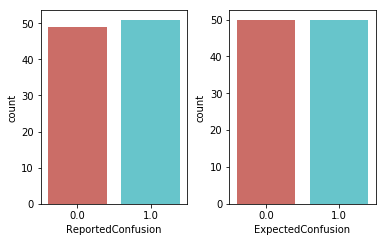

In [5]:
reported_confused = [i for i in dataset_mean["ReportedConfusion"] if i == 1]
reported_not_confused = [i for i in dataset_mean["ReportedConfusion"] if i == 0]
expected_confused = [i for i in dataset_mean["ExpectedConfusion"] if i == 1]
expected_not_confused = [i for i in dataset_mean["ExpectedConfusion"] if i == 0]

print("ReportedConfusion: Class1(confused): n=%d, Class2(not-confused): m=%d" % (len(reported_confused),len(reported_not_confused)))
print("ExpectedConfusion: Class1(confused): n=%d, Class2(not-confused): m=%d" % (len(expected_confused),len(expected_not_confused)))


fig, ax =plt.subplots(1,2)
sns.countplot(x="ReportedConfusion",data=dataset_mean,palette='hls',ax=ax[0])
sns.countplot(x="ExpectedConfusion",data=dataset_mean,palette='hls',ax=ax[1])
fig.tight_layout(pad=3, w_pad=0.5, h_pad=1)
fig.show()

Both outcome varaibales have balanced classes, while the ExpectedConfusion variable is even perfectly balanced.

## E2 Logistic Regression

In [6]:
X = dataset_mean.iloc[:,5:13]
Y = dataset_mean["ReportedConfusion"]

logReg = LogisticRegression(C = 1000000) # in order to use no regularization 
logReg.fit(X,Y)

Y_pred = logReg.predict(X)
print(classification_report(Y, Y_pred,target_names = ["not-confused","confused"]))

              precision    recall  f1-score   support

not-confused       0.65      0.57      0.61        49
    confused       0.63      0.71      0.67        51

 avg / total       0.64      0.64      0.64       100



Because our outcome variable is balanced, we decided to use the average total precision in order to calculate the accuracy of the predictions.

## E3 10-fold cross-validation

In [7]:
kfold = model_selection.KFold(n_splits=10, random_state=0)
logreg= LogisticRegression(C=1000000)
results = model_selection.cross_val_score(logreg, X, Y, cv=kfold, scoring="accuracy")
print("10-fold cross validation average accuracy: %.2f\n10-fold cross validation standard deviation: %.2f" % (results.mean(),results.std()))

10-fold cross validation average accuracy: 0.56
10-fold cross validation standard deviation: 0.11


## E4 Improving Predictions

In [8]:
current_best_mean = results.mean()
current_best_std = results.std()
selection = []
for i in range(1,9):
    logreg= LogisticRegression()
    selector = RFE(logreg, i)
    selector = selector.fit(X, Y)
    supported = selector.support_
    ranking = selector.ranking_
    X_selected = X.iloc[:,supported]
    logreg= LogisticRegression(C=1000000)
    res = model_selection.cross_val_score(logreg, X_selected, Y, cv=kfold, scoring="accuracy")
    if res.mean() >= current_best_mean:
        current_best_mean = res.mean()
        current_best_std = res.std()
        selection = supported

print("10-fold cross validation average accuracy after feature RFE: %.2f\n10-fold cross validation standard deviation: %.2f" % (current_best_mean,current_best_std))
# muss hier nich selection anstatt supported stehen? supported ist an der stelle immer das von der letzten iteration der loop
print("Selected Features:", list(X.iloc[:,selection]))

10-fold cross validation average accuracy after feature RFE: 0.57
10-fold cross validation standard deviation: 0.09
Selected Features: ['Delta', 'Theta', 'Alpha 2', 'Beta 1', 'Beta 2', 'Gamma 1', 'Gamma 2']


# 2 Linear and quadratic discriminant analysis

In [9]:
# Linear Discriminant Analysis
lda = LinearDiscriminantAnalysis(solver="lsqr", store_covariance=True)
lda.fit(X, Y)
Y_pred = lda.predict(X)
print("Prediction with Linear Discriminant Analysis")
print(classification_report(Y, Y_pred,target_names = ["not-confused","confused"]))

# Quadratic Discriminant Analysis
qda = QuadraticDiscriminantAnalysis(store_covariances=True)
qda.fit(X, Y)
Y_pred= qda.predict(X)
print("Prediction with Quadratic Discriminant Analysis")
print(classification_report(Y, Y_pred,target_names = ["not-confused","confused"]))

Prediction with Linear Discriminant Analysis
              precision    recall  f1-score   support

not-confused       0.66      0.78      0.71        49
    confused       0.74      0.61      0.67        51

 avg / total       0.70      0.69      0.69       100

Prediction with Quadratic Discriminant Analysis
              precision    recall  f1-score   support

not-confused       0.68      0.90      0.77        49
    confused       0.86      0.59      0.70        51

 avg / total       0.77      0.74      0.73       100



/Users/paule/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:664: DeprecationWarning: 'store_covariances' was renamed to store_covariance in version 0.19 and will be removed in 0.21.
  DeprecationWarning)


### Performance difference : linear VS. quadratic discriminant analysis
The accuracy performances for LDA and QDA differ by 7% in precison. This is especially caused by the performance for predicting the not-confused class and might indicate that a quadratic boundary is more accurate for class predictions.

### Performance difference : logistic regression VS. linear discriminant analysis
The accuracy performances for LogReg and LDA differ by 6% in precision. In contrast to the LogReg LDA has a higher precision for predicting the confused class. While LDA makes the assumption of a gaussian density for the predictors, logistic regression waives assumptions of the data and is more general. In our case with a small data set, LDA performs better on the data, which might indicate that this assumption holds true and the true density of the predictors is normal distributed. 

Interesting in this case would be taking non linearity in consideration with logistic models.

# 3 Penalized logistic regression

/Users/paule/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


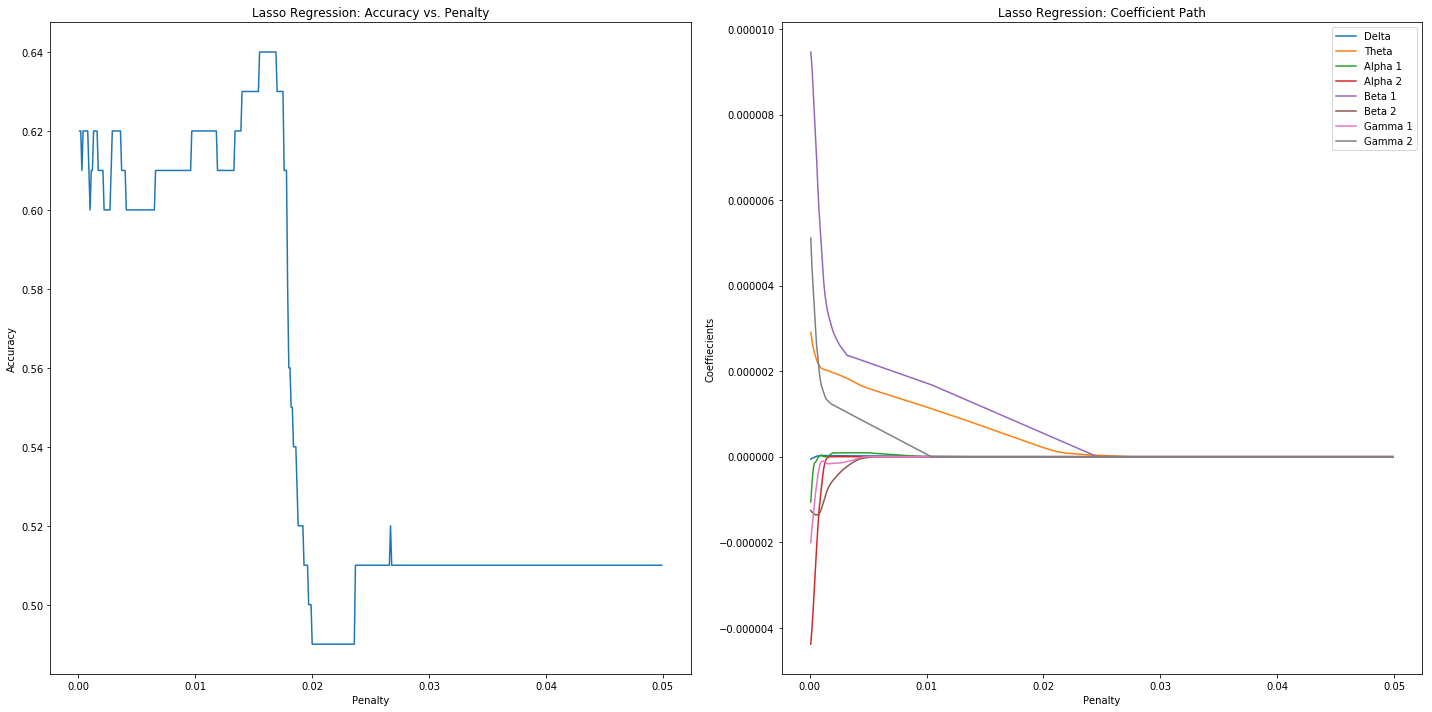

In [10]:
penalty = np.arange(0.0001, 0.05, 0.0001)
acc = np.zeros(len(penalty))
coefs = np.zeros((len(penalty),8))
kfold = model_selection.KFold(n_splits=10, random_state=0)
for i,c in enumerate(penalty):
    scores = np.zeros(10)
    coef = np.zeros((10,8))
    count = 0

    for train_index,test_index in kfold.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        Y_train, Y_test = Y.iloc[train_index], Y.iloc[test_index]
        lasso = Lasso(alpha = c,normalize = True,fit_intercept=True)
        
        lasso.fit(X_train, Y_train)
        
        coef[count] = lasso.coef_
    
        Y_pred_lasso = lasso.predict(X_test)
        Y_pred_lasso = [1 if x>=0.5 else 0  for x in Y_pred_lasso]
        
        scores[count] = accuracy_score(Y_test, Y_pred_lasso, normalize=True)
        count += 1
    acc[i] = scores.mean(axis=0)
    coefs[i] = coef.mean(axis=0)
    
    
fig,ax = plt.subplots(1,2,figsize= (20,10))

ax[0].plot(penalty,acc)

for i in range(8):
    ax[1].plot(penalty,coefs[:,i],label = X.columns.values[i])
    
ax[1].legend()
ax[0].set(xlabel = "Penalty",ylabel = "Accuracy",title="Lasso Regression: Accuracy vs. Penalty")
ax[1].set(xlabel = "Penalty",ylabel = "Coeffiecients",title="Lasso Regression: Coefficient Path")


fig.tight_layout()
fig.show()

We created the plots for a penalty range from 0.001 to 0.05. 
For the accuracy you can see that using a penalty below 0.017 can improve your predictions. In our case it reaches its maximum at around 0.015 with a cross validated accuracy of 64%. Increasing the penalty even more leads to a dramatic decrease in performance. In order to make the best predictions for new data, we would prefer a lasso regression with a penalty weight of $\approx$ 0.015. 
Looking at the plot for the coefficients over penalty cou can see how the single features drop out of the model when taking the sparsity of the model more into account. With higher penalty the last features which are still included in the model are beta_1 and theta indicating a high value for our prediction.

/Users/paule/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


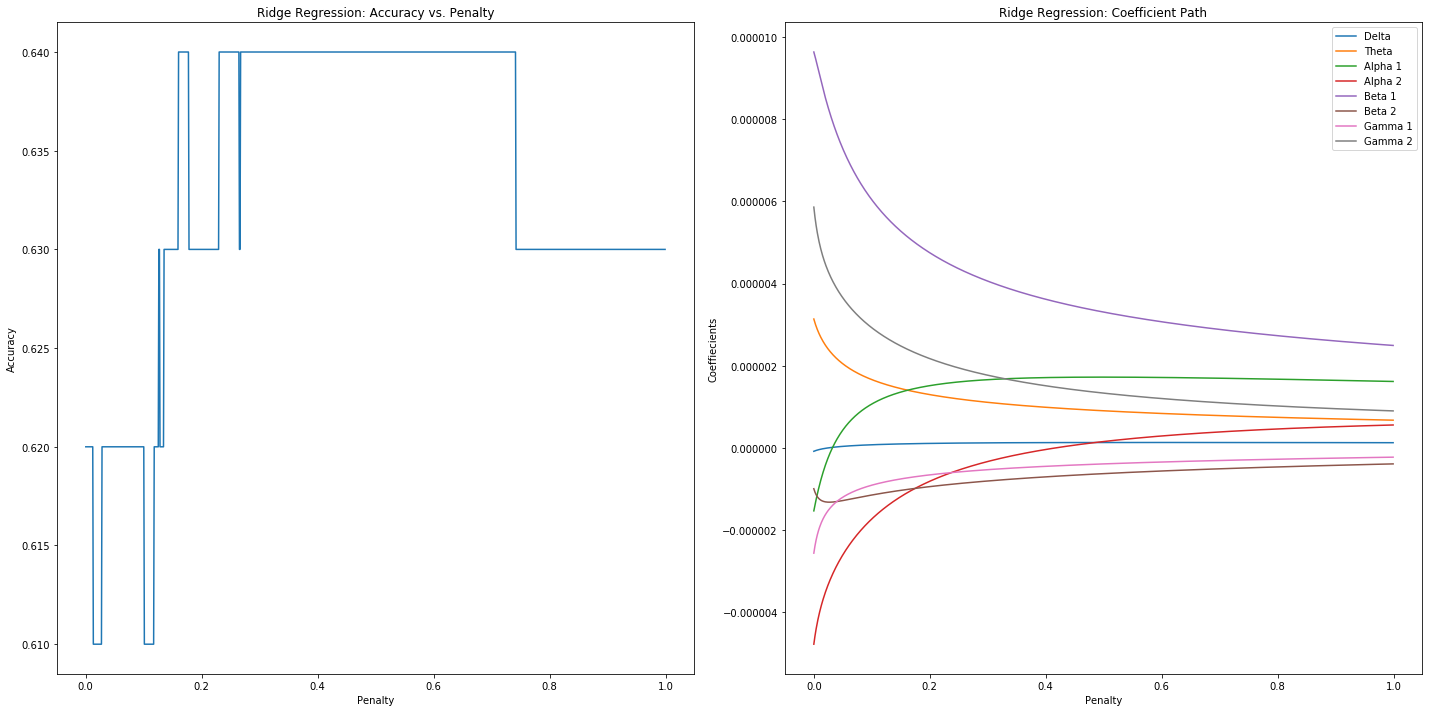

In [11]:
penalty = np.arange(0.0001, 1, 0.001)
acc = np.zeros(len(penalty))
coefs = np.zeros((len(penalty),8))
kfold = model_selection.KFold(n_splits=10, random_state=0)
for i,c in enumerate(penalty):
    scores = np.zeros(10)
    coef = np.zeros((10,8))
    count = 0

    for train_index,test_index in kfold.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        Y_train, Y_test = Y.iloc[train_index], Y.iloc[test_index]
        
        ridge = Ridge(alpha = c,normalize = True,fit_intercept=True)
        ridge.fit(X_train, Y_train)
        
        coef[count] = ridge.coef_
        
        Y_pred_ridge = ridge.predict(X_test)
        Y_pred_ridge = [1 if x>=0.5 else 0  for x in Y_pred_ridge]
        
        scores[count] = accuracy_score(Y_test, Y_pred_ridge, normalize=True)
        count += 1
    
    acc[i] = scores.mean(axis=0)
    coefs[i] = coef.mean(axis=0)
    
fig,ax = plt.subplots(1,2,figsize = (20,10))

ax[0].plot(penalty,acc)
for i in range(8):
    ax[1].plot(penalty,coefs[:,i],label = X.columns.values[i])

ax[1].legend()
ax[0].set(xlabel = "Penalty",ylabel = "Accuracy",title="Ridge Regression: Accuracy vs. Penalty")
ax[1].set(xlabel = "Penalty",ylabel = "Coeffiecients",title="Ridge Regression: Coefficient Path")
fig.tight_layout()
fig.show()

For the ridge regression we created the plot for a larger range from 0.001 to 1. The Plot for the accuracy shows a more stable behavior and has its maximum accuracy for penaltys between 0.3 and 0.7. In contrast to the l1-norm you can see that you have a wider range of penalty values influencing the model predictions. The coefficient path shows that even for high penaltys almost all features are still included in the model. 

# 4 Non-linear and tree-based classification models

In [12]:
knn = KNeighborsClassifier() # default n = 5
mlp = MLPClassifier(hidden_layer_sizes=(10,), activation = "logistic") # MLP with one hidden layer with 10 neurons
svc = SVC() # default with gaussian rbf kernel
rfc = RandomForestClassifier() # default n = 10

kfold = model_selection.KFold(n_splits=10, random_state=0)

results_knn = model_selection.cross_val_score(knn, X, Y, cv=kfold, scoring="accuracy")
results_mlp = model_selection.cross_val_score(mlp, X, Y, cv=kfold, scoring="accuracy") 
results_svc = model_selection.cross_val_score(svc, X, Y, cv=kfold, scoring="accuracy")
results_rfc = model_selection.cross_val_score(rfc, X, Y, cv=kfold, scoring="accuracy")

print("K-Nearest-Neighbor crossvalidated accuracy:", results_knn.mean())
print("Multi-layer Perceptron classifier crossvalidated accuracy:", results_mlp.mean())
print("C-Supported Vector Classification crossvalidated accuracy:",results_svc.mean())
print("RandomForrst Classification crossvalidated accuracy:", results_rfc.mean())
            

K-Nearest-Neighbor crossvalidated accuracy: 0.67
Multi-layer Perceptron classifier crossvalidated accuracy: 0.55
C-Supported Vector Classification crossvalidated accuracy: 0.45
RandomForrst Classification crossvalidated accuracy: 0.58


/Users/paule/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


### Base-line correction

In [36]:
# substract mean for each subject (original data) !!!!

X_pre = np.zeros(X.shape)
X_scaled = {}
for i,c in enumerate(X.columns.values):
    for j in range(10):
        X_pre[j:(j+1)*10,i] = preprocessing.scale(X.iloc[j:(j+1)*10,i])
    X_scaled[c] = X_pre[:,i] #


X_scaled = pd.DataFrame(data=X_scaled)


# 5 Better preprocessing makes a better classifier

In [35]:
kfold = model_selection.KFold(n_splits=10, random_state=0)

qda = QuadraticDiscriminantAnalysis(store_covariances=True)
ridge = Ridge(alpha = 0.5,normalize = True,fit_intercept=True)
mlp = MLPClassifier(hidden_layer_sizes=(10,), activation = "logistic") # MLP with one hidden layer with 10 neurons
knn = KNeighborsClassifier() # default n = 5


results_mlp = model_selection.cross_val_score(mlp, X_scaled, Y, cv=kfold, scoring="accuracy")
results_knn = model_selection.cross_val_score(knn, X_scaled, Y, cv=kfold, scoring="accuracy")
results_qda = model_selection.cross_val_score(qda, X_scaled, Y, cv=kfold, scoring="accuracy")

results_ridge = np.zeros(10)

count = 0

for train_index,test_index in kfold.split(X_scaled):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    Y_train, Y_test = Y.iloc[train_index], Y.iloc[test_index]
    
    ridge.fit(X_train, Y_train)
    
    Y_pred_ridge = ridge.predict(X_test)
    Y_pred_ridge = [1 if x>=0.5 else 0  for x in Y_pred_ridge] #use threshold 0.5
        
    results_ridge[count] = accuracy_score(Y_test, Y_pred_ridge, normalize=True)
    count += 1
    


print("10-fold cross validation average accuracy QDA: %.2f\n standard deviation: %.2f" % (results_qda.mean(),results_qda.std()))
print("10-fold cross validation average accuracy Ridge: %.2f\n standard deviation: %.2f" % (results_ridge.mean(),results_ridge.std()))
print("10-fold cross validation average accuracy MLP: %.2f\n standard deviation: %.2f" % (results_mlp.mean(),results_mlp.std()))
print("10-fold cross validation average accuracy KNN: %.2f\n standard deviation: %.2f" % (results_knn.mean(),results_knn.std()))

/Users/paule/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/paule/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/paule/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/paule/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged 

10-fold cross validation average accuracy QDA: 0.56
 standard deviation: 0.14
10-fold cross validation average accuracy Ridge: 0.64
 standard deviation: 0.17
10-fold cross validation average accuracy MLP: 0.65
 standard deviation: 0.22
10-fold cross validation average accuracy KNN: 0.65
 standard deviation: 0.19


/Users/paule/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/paule/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/paule/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:664: DeprecationWarning: 'store_covariances' was renamed to store_covariance in version 0.19 and will be removed in 0.21.
  DeprecationWarning)
/Users/paule/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:664: DeprecationWarning: 'store_covariances' was renamed to store_covariance in version 0.19 and will be removed in 0.21.
  DeprecationWarning)
/Users/paule/anaconda3

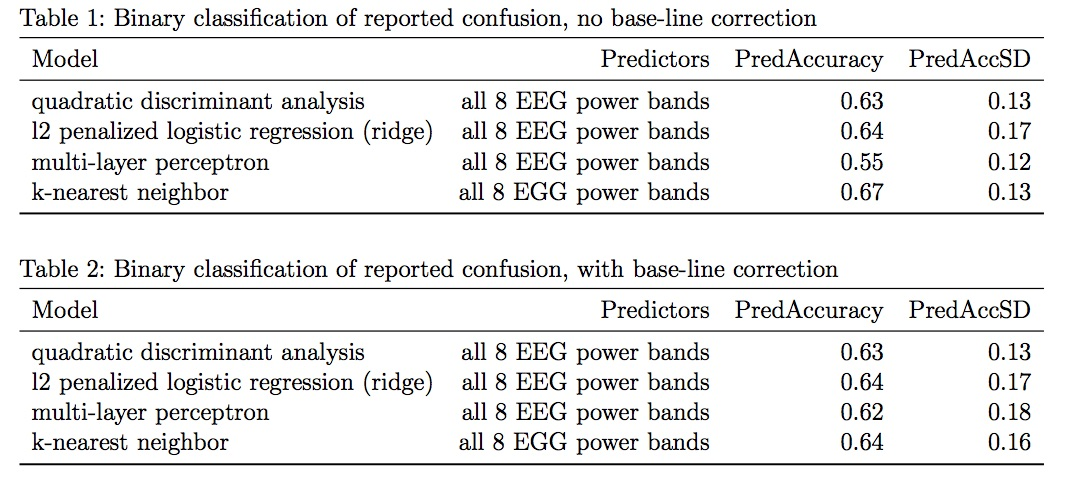

In [93]:
from IPython.display import Image
Image("Tables.jpg")